# Map Reduce II - Clustering Coefficient

# 4.

Now suppose that the web graph is undirected. This means, that we convert each directed edge to an undirected one. There are no multiple edges, i.e. if both (u,v) \in E and (v,u) \in E, then we assume, that there is only one edge {u,v}.  Solve Problem 37 from the problem set by Dr. M. Gębala assuming that the graph is undirected. For each vertex v \in V you need to determine the clustering coefficient c(v) of v.  It is defined as the ratio of the actual number of edges between the neighbors of v in G to the number of all possible edges between the neighbors of v (there are at most deg(v) (deg(v) - 1)/2 of them). Design and implement the procedures for mapper and reducer. Also write the procedure for determining the average clustering coefficient for the graph. Try to make your implementation as efficient as possible.

# 5.
Write a short paragraph in which you summarize the general idea of algorithms used in 5. Try to estimate how many times each edge / each vertex is processed.


## The idea 
The clustering coefficient for a node can be defined as a following: 
$$ C_i = \frac{\text{number of triangles (triplets) with a vertex} }{ \text{total possible number of triples} }$$

If $k_i$ is a node's degree the total possible number of triplets is equal to $\frac{k_i(k_i-1)}{2}$. Therfore, we can write:

$$ C_i = \frac{2 \cdot \text{number of triangles (triplets) with a vertex} }{k_i(k_i-1)}$$.

Now let's observe that the adjacency matrix with 0s and 1s in rows and columns can represent our graph. Such matrix multiplication to the $n$ power gives us the number of possible paths that begin at i (row i of the matrix = node i) and end at j ( j column of the matrix - node j). If we consider the diagonal of an adjacency matrix $A^3$ we will get the desired number of triplets. Therfore to calculate the clustering coefficient it is enough to calculate the thirs power of an adjacency matrix of a graph and divide its diagonal values by an appropriate product of the node degree value. 

### Matrix preparation by Map Reduce

Firstly, we need a matrix representation of the graph - that is simple: matrix will be represented in a coordinate sparse format only (row = node 1 from an edge list,column = node 2 from an edge list,value = 1) will be considered. 

First map: (node1, node2) -> (node1, node2,1)

### Matrix Multiplication by Map Reduce
Let's define the multiplication of A and B as follows:

First map for A: (i,j , $a_{ij}$) -> (j, ("A, i , $a{ij}$) )

First map for B: (j,k, $b_{jk}$) ->  (j, ("B", k, $b_{jk}$ )

First reducer we group by the jth column our data so that we obtain records of the kind 

(j, ("A",x,y), ("A,z,w), ..., ("B", t,m), ("B",k,h))

Second map : we need to emit the (i,k, value pairs) - all combintations from elemnts multiplication.

For each pair ("A", i, sth1), ("B", k, sth2) in a j record we emit ( (i,k), sth1 $\cdot$ sth2). 

The only thing left is the summation of the values by the key to obtain ((i,k), value).

Our power 3 of an adjaceny matrix is computed as multiply( multiply(A,A), A) then the elements from the diagonal are extracted and saved as the doubled number of triangles coming out from a node.

### Degree computation by Map Reduce
The total degree for each node is computed as follows from the list (node1, node2, 1) generated after creating an undirected network (for each edge from the directed list emit (node1, node2, 1) and (node2, node1,1) ).

Degree:

Map for each pair (node1, node2, 1) emit (node1, 0.5) (node2, 0.5) to obtain the occurence counts of each node. Then we reduce by key by summing the counts. 

### Final value

We join the tables for the degree and for the number of triangles and then divide for each pair the number of triangles by the degree. Such approach will generate a sparse table, if some node has a 0 clustering coefficient it won't be present in our table.

### Average clustering
The average clustering is calclated by summing all the clustering coefficient values and dividing them by the number of nodes. 

# Implementation

In [1]:
####### to nie zadziała!!
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.network.timeout", "7500s") \
    .config("spark.executor.heartbeatInterval","7200s")\
    .config("spark.storage.blockManagerSlaveTimeoutMs", "7500s")\
    .getOrCreate()

In [1]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! trzeba tą sesję zaktualizowac tak by timeout był większy i ten heartbeat interval
#.set("spark.storage.blockManagerSlaveTimeoutMs", "7500s")\
#OLD SESION ---------------
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local').set("spark.network.timeout", "7500s")\
        .set("spark.executor.heartbeatInterval","7200s").set("spark.storage.blockManagerSlaveTimeoutMs", "72000s")\
        .set("spark.worker.timeout", "72000s").set("spark.ui.showConsoleProgress", "true")
#conf.set("spark.network.timeout", "600s")
#conf.set("spark.executor.heartbeatInterval","3600s")
sc = pyspark.SparkContext('local[4]',conf=conf)
spark = SparkSession(sc)#.getOrCreate()

In [2]:
configurations = spark.sparkContext.getConf().getAll()
for conf in configurations:
    print(conf)

('spark.master', 'local[4]')
('spark.app.name', 'appName')
('spark.executor.heartbeatInterval', '7200s')
('spark.executor.id', 'driver')
('spark.driver.host', 'LAPTOP-AR3KTOMI')
('spark.storage.blockManagerSlaveTimeoutMs', '72000s')
('spark.worker.timeout', '72000s')
('spark.rdd.compress', 'True')
('spark.network.timeout', '7500s')
('spark.serializer.objectStreamReset', '100')
('spark.driver.port', '56441')
('spark.app.id', 'local-1607593482499')
('spark.submit.pyFiles', '')
('spark.submit.deployMode', 'client')
('spark.ui.showConsoleProgress', 'true')


In [14]:
from pyspark.sql.functions import split
df = spark.read.csv("test3.txt",sep='\n')
df = df.filter(~df._c0.contains('#')) #removing the first 5 rows
#df.show(10)

split_col = pyspark.sql.functions.split(df['_c0'], ' ')
df = df.withColumn('Node1', split_col.getItem(0))
df = df.withColumn('Node2', split_col.getItem(1))
df = df.drop("_c0")

rdd = df.rdd
rdd.take(20)

[Row(Node1='1', Node2='2'),
 Row(Node1='1', Node2='3'),
 Row(Node1='2', Node2='3'),
 Row(Node1='1', Node2='8'),
 Row(Node1='8', Node2='9'),
 Row(Node1='2', Node2='8'),
 Row(Node1='2', Node2='9'),
 Row(Node1='3', Node2='4'),
 Row(Node1='4', Node2='5'),
 Row(Node1='5', Node2='6'),
 Row(Node1='4', Node2='6'),
 Row(Node1='4', Node2='7'),
 Row(Node1='7', Node2='10')]

In [3]:
def emition(x):
    return (int(x[1]),int(x[0]),1), (int(x[0]),int(x[1]),1) # 1 added for making easily a matrix
    #return ((int(x[1]),int(x[0])),1) , ((int(x[0]),int(x[1]) ),1) 
            
#undirected = rdd.flatMap(emition).distinct()

In [5]:
undirected = rdd.flatMap(emition).distinct()
undirected.take(10)

[(2, 1, 1),
 (1, 2, 1),
 (3, 1, 1),
 (1, 3, 1),
 (3, 2, 1),
 (2, 3, 1),
 (8, 1, 1),
 (1, 8, 1),
 (9, 8, 1),
 (8, 9, 1)]

In [4]:
def emition_A(x): #A_ij
    node1 = x[0] # position i=node1, j=node2 in a mtrix, k index from a new matrix
    node2 = x[1]
    value = x[2]
    return (node2,("A",node1,value))

def emition_B(x): #B_jk
    node1 = x[0] # position j=node1, k=node2 in a mtrix, k index from a new matrix
    node2 = x[1]
    value = x[2]
    return (node1,("B",node2,value))

In [5]:
from itertools import combinations
import itertools
#nie ma wierzchołka zerowego wszystko liczymy od 1, a python liczy od zera...
# czyli (i,k) values musza byc od 1 tez

def multiplication(x): #(j , A... B...)
    lista = x[1]
    A_values_at_j = [i for i in lista if i[0]=="A"]
    B_values_at_j = [i for i in lista if i[0]=="B"]
    
    #unzip = list(zip(*lista)) # (A...) (B...)
    #A_values_at_j = unzip[0]
    #B_values_at_j = unzip[1]
    #format : A: (A, node1 =i, value), (A, node2,value)...., B: (B, node2 =k, value)
    # i = A_values_at_j[i-1][1]
    # k = B_values_at_j[k-1][1]
    i_k_pairs = [ ( (A_values_at_j[i-1][1], B_values_at_j[k-1][1] ), #key i k
                   A_values_at_j[i-1][-1]*B_values_at_j[k-1][-1])  #value
                 for i, k in itertools.product(range(1,len(A_values_at_j)+1), range(1,len(B_values_at_j)+1))] 
    
    return i_k_pairs

In [6]:
def matrix_multiplication(A_rdd, B_rdd):
    #Mapping
    A  = A_rdd.map(emition_A)
    B = B_rdd.map(emition_B)
    #joined = A.join(B) bylo join zmieniam na union
    joined = A.union(B)
    
    # Reducing by key
    to_return = joined.groupByKey().map(lambda x: (x[0], list(x[1])))
    
    # Mapping to create (i,k, value) tuples
    to_return = to_return.flatMap(multiplication)
   
    #Reducing and summing  - aggregating the (i,k) values ((i,k), v1), ((i,k),v2)-> ((i,k), v1+v2)
    to_return = to_return.reduceByKey(lambda x, y: x + y)
    
    return to_return

In [7]:
def doubled_number_of_triangles(rdd):
    square = matrix_multiplication(rdd,rdd)
    square.take(5)
    print("SQUARED")
    square = square.map(lambda x: (x[0][0], x[0][1], x[1]) )
    cube = matrix_multiplication(square, rdd)
    cube.take(5)
    print("TRIPLED")
    cube = cube.filter(lambda x: x[0][0] == x[0][1]) #take only diagonal elements of a multiplied matrix
    return cube

In [8]:
def degree_emition(x): # for each edge emit count for both members of an edge
    return ((x[0],x[0]),0.5), ((x[1],x[1]),0.5)
    
def calculate_degree(rdd): # assumed undirected netwrok with each edge occuring twice for bot nodes
    counts = rdd.flatMap(degree_emition)
    counts = counts.reduceByKey(lambda x, y: x + y)
    return counts

In [9]:
def final_division(x):
    node = x[0][0]
    measures = x[1]
    triangles = measures[0] # doubled number is needed in the formula
    degree = measures[1]
    return (node, triangles/(degree*(degree-1)))

In [11]:
degree = calculate_degree(undirected)
triangles = doubled_number_of_triangles(undirected)

clustering = triangles.join(degree) # joining to divide
clustering = clustering.map(final_division)

In [12]:
def average_clustering(rdd_clustering, degree):
    number_of_nodes = degree.count()
    avg_sum = rdd_clustering.map(lambda x: ("mean", x[1])).reduceByKey(lambda x,y: x+y)
    avg = avg_sum.map(lambda x: ("mean", x[1]/number_of_nodes) )
    return avg

### Proof of correctness - comparison of the results for a simple example with networkx

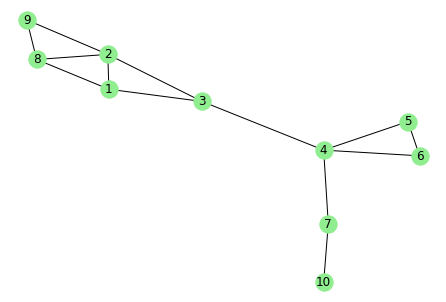

In [44]:
nx.draw(G, with_labels = True, node_color = "lightgreen")

In [30]:
# Results from the MapReduce
clustering.take(30)

[(1, 0.6666666666666666),
 (5, 1.0),
 (9, 1.0),
 (3, 0.3333333333333333),
 (6, 1.0),
 (2, 0.5),
 (8, 0.6666666666666666),
 (4, 0.16666666666666666)]

In [31]:
average_clustering(clustering,degree).take(1)

[('mean', 0.5333333333333333)]

In [35]:
#Networkx 
import networkx as nx
G = nx.read_edgelist("test3.txt")
c = nx.clustering(G)
print( c )
print(sum([c[i] for i in c])/len([c[i] for i in c]) )

{'1': 0.6666666666666666, '2': 0.5, '3': 0.3333333333333333, '8': 0.6666666666666666, '9': 1.0, '4': 0.16666666666666666, '5': 1.0, '6': 1.0, '7': 0, '10': 0}
0.5333333333333333


# Web graph 

In [15]:
df = spark.read.csv("web-Stanford.txt.gz",sep='\n')
df = df.filter(~df._c0.contains('#')) #removing the first 5 rows
#df.show(10)

split_col = pyspark.sql.functions.split(df['_c0'], '\t')
df = df.withColumn('Node1', split_col.getItem(0))
df = df.withColumn('Node2', split_col.getItem(1))
df = df.drop("_c0")

#rdd = df.rdd
#rdd.take(10)

# Limit the data set - computational problems
Memory error, socket timeout, ...

In [21]:
#divide graph in a half - memory and run times
df_head = df.limit(25000)
rdd = df_head.rdd

In [22]:
rdd.take(10)

[Row(Node1='1', Node2='6548'),
 Row(Node1='1', Node2='15409'),
 Row(Node1='6548', Node2='57031'),
 Row(Node1='15409', Node2='13102'),
 Row(Node1='2', Node2='17794'),
 Row(Node1='2', Node2='25202'),
 Row(Node1='2', Node2='53625'),
 Row(Node1='2', Node2='54582'),
 Row(Node1='2', Node2='64930'),
 Row(Node1='2', Node2='73764')]

In [23]:
# Emitting the (node1, node2, 1) and (node2, node1, 1)
undirected = rdd.flatMap(emition).distinct() # removing the duplicates
undirected.take(5)

[(6548, 1, 1), (1, 6548, 1), (15409, 1, 1), (1, 15409, 1), (57031, 6548, 1)]

In [24]:
degree = calculate_degree(undirected)
degree.take(5)

[((6548, 6548), 2.0),
 ((1, 1), 2.0),
 ((15409, 15409), 2.0),
 ((57031, 57031), 1.0),
 ((13102, 13102), 1.0)]

In [26]:
triangles = doubled_number_of_triangles(undirected)

SQUARED
TRIPLED


In [27]:
triangles.take(5)

[((153900, 153900), 8),
 ((173905, 173905), 2),
 ((65179, 65179), 22),
 ((90591, 90591), 36),
 ((264982, 264982), 96)]

In [28]:
clustering = triangles.join(degree) # joining to divide

In [29]:
clustering = clustering.map(final_division)

In [30]:
clustering.take(20)

[(173905, 1.0),
 (65179, 0.5238095238095238),
 (90591, 0.023076923076923078),
 (253245, 0.08097165991902834),
 (253689, 0.47953216374269003),
 (222873, 0.375),
 (22789, 0.11904761904761904),
 (246741, 0.9166666666666666),
 (273803, 0.9960474308300395),
 (274869, 0.9960474308300395),
 (169971, 0.2),
 (85191, 0.23809523809523808),
 (86507, 1.0),
 (203033, 0.28888888888888886),
 (206531, 0.05555555555555555),
 (7819, 0.6666666666666666),
 (12717, 0.6666666666666666),
 (15557, 0.6666666666666666),
 (59755, 0.05555555555555555),
 (62745, 0.6666666666666666)]

In [31]:
average_clustering(clustering,degree).take(1)

[('mean', 0.18461202845423508)]

### Due to the problems regarding my computational resources I decided to limit the data set to first 35000 records - limit of my laptop (error : za mało miejsca na dysku). 

# Complexity of the algorithm
after preparing the data the algorithm for clustering itself seems to take:
Matrix multiplication:
* emition A,B each node 2k where k is degree, each edge 2
* when we reduce to the elements of the matrix it is hard to furtherly track dependence of the matrix multiplication on the number of times the edges and nodes are transformed. However, becuase the matrices are implemented in a sparse way, the complexity of the whole algorthim of $A^3$ is not O($N^3$) instead it is O(number of nodes that have edges), therefore each edge seems to generate at least 3 next calculations without taking into account intermediate steps used for the data organization and prepartion. Finally when the matrix computation is completed we are only interested in the diagnoal elements so the operation is O( number of nodes that have edges) - each node processed one additional time.
* degree calculation was already described in the previous task
* divison - only node dependent one operation

In [13]:
# Calculating the degree and number of triangles
degree = calculate_degree(undirected)
triangles = doubled_number_of_triangles(undirected)

clustering = triangles.join(degree) # joining to divide
clustering = clustering.map(final_division)

In [ ]:
average_clustering(clustering,degree).take(1)